In [1]:
# Package import
import pyspark
import pandas as pd
import numpy as np
import re
from datetime import datetime
from dateutil.parser import parse

from pyspark.sql import SparkSession
from pyspark.sql.functions import when
from pyspark.sql.functions import col
from pyspark.sql.functions import lit
from pyspark.pandas.config import set_option, reset_option, get_option
from pyspark.sql import functions as F
from pyspark.sql.window import Window

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
# Spark Session
spark = SparkSession.builder.master("yarn").appName('Task_3').getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2022-02-10 13:05:14,671 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
2022-02-10 13:05:15,575 WARN util.Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
2022-02-10 13:05:15,576 WARN util.Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [3]:
# Read json data
all_json = spark.read.format('json').load("/datasets/covid19/*.json")

## Analysis of Tweets that Have Stay-Home Related Hashtags

In [4]:
# Get the tweets containing stay home related hashtags
tweet_home_df = all_json.filter(all_json.text.contains('stayhome' or 
                                                    'stayhomestaysafe' or
                                                    'stayathome' or 
                                                    'stayhomesavelives' or 
                                                    'stayathomeandstaysafe' or 
                                                    'workfromhome' or 
                                                    'stayathomesavelives' or 
                                                    'staysafestayhome' or 
                                                    'workingfromhome' or 
                                                    'healthyathome' or 
                                                    'stayathomechallenge' or 
                                                    'saferathome' or 
                                                    'home' or 
                                                    'homeoffice' or 
                                                    'stayhomesavelifes' or 
                                                    'oneworldtogetherathome' or 
                                                    'homequarantine' or 
                                                    'stayinghome'))

tweet_home = tweet_home_df.filter(tweet_home_df.lang == "en")
tweet_home = tweet_home.withColumn("date", F.regexp_extract(tweet_home['created_at'], r'(\d{4}-\d{2}-\d{2})',0)).cache()
tweet_home = tweet_home.groupBy("date").count()
tweet_home = tweet_home.sort("date")
tweet_home.show(truncate=False)

+----------+-----+
|date      |count|
+----------+-----+
|2020-03-29|2795 |
|2020-03-30|2743 |
|2020-03-31|3063 |
|2020-04-01|3079 |
|2020-04-02|2926 |
|2020-04-03|2546 |
|2020-04-04|3093 |
|2020-04-05|3521 |
|2020-04-06|3403 |
|2020-04-07|3013 |
|2020-04-08|3238 |
|2020-04-09|3642 |
|2020-04-10|3400 |
|2020-04-11|2602 |
|2020-04-12|2259 |
|2020-04-13|2126 |
|2020-04-14|2772 |
|2020-04-15|2807 |
|2020-04-16|2977 |
|2020-04-17|3064 |
+----------+-----+
only showing top 20 rows



In [5]:
# Convert to Pandas.DateFrame
pandasDF = tweet_home.toPandas()
pandasDF['date'] = pandasDF['date'].apply(lambda x: parse(x)).copy()
pandasDF_week = pandasDF.groupby([pd.Grouper(key='date', freq='w')]).sum(min_count=1).reset_index()
print(pandasDF_week)

        date  count
0 2020-03-29   2795
1 2020-04-05  20971
2 2020-04-12  21557
3 2020-04-19  18370
4 2020-04-26  18144
5 2020-05-03   6528


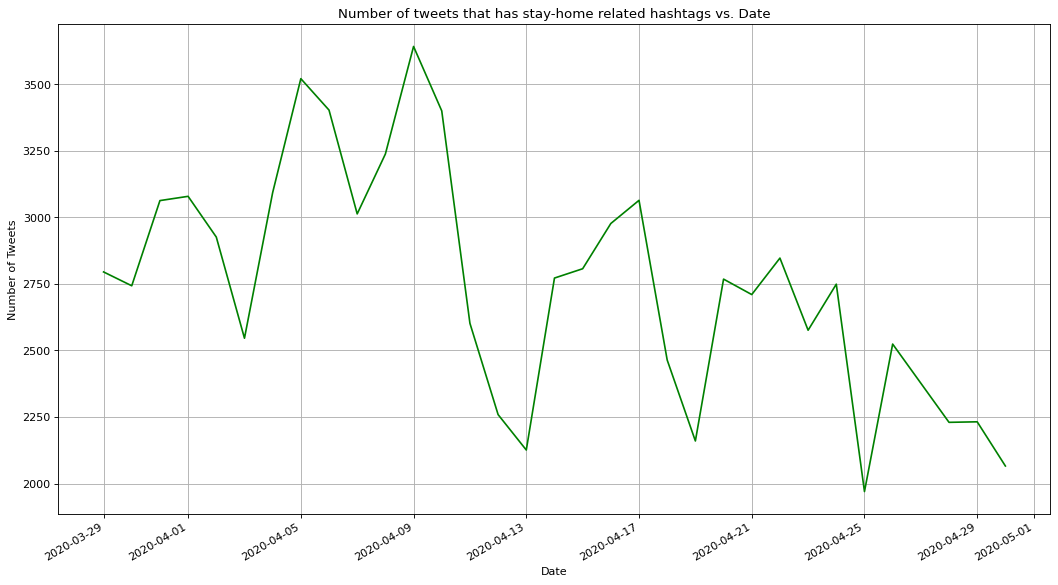

In [60]:
# Plot
plt.figure(figsize=(16, 9), dpi=80)
plt.plot(pandasDF['date'], pandasDF['count'], color="g")

plt.gcf().autofmt_xdate()

plt.xlabel('Date') 
plt.ylabel('Number of Tweets') 
  
# displaying the title
plt.title("Number of tweets that has stay-home related hashtags vs. Date")
plt.savefig('./task3_1.png')
plt.grid()

In [7]:
# Get all the tweets
tweet_all = all_json.filter(all_json.lang == "en")
tweet_all = tweet_all.withColumn("date", F.regexp_extract(tweet_all['created_at'], r'(\d{4}-\d{2}-\d{2})',0)).cache()
tweet_all = tweet_all.groupBy("date").count()
tweet_all = tweet_all.sort("date")
tweet_all.show(truncate=False)

+----------+------+
|date      |count |
+----------+------+
|2020-03-29|306499|
|2020-03-30|308045|
|2020-03-31|369848|
|2020-04-01|333553|
|2020-04-02|322137|
|2020-04-03|295516|
|2020-04-04|253069|
|2020-04-05|250301|
|2020-04-06|318601|
|2020-04-07|235706|
|2020-04-08|293814|
|2020-04-09|262880|
|2020-04-10|236448|
|2020-04-11|172610|
|2020-04-12|128890|
|2020-04-13|123154|
|2020-04-14|249125|
|2020-04-15|258597|
|2020-04-16|291295|
|2020-04-17|275805|
+----------+------+
only showing top 20 rows



In [8]:
# Convert to Pandas.DateFrame
pandasDF_all = tweet_all.toPandas()
pandasDF_all['date'] = pandasDF_all['date'].apply(lambda x: parse(x)).copy()
pandasDF_all_week = pandasDF_all.groupby([pd.Grouper(key='date', freq='w')]).sum(min_count=1).reset_index()
print(pandasDF_all_week)

        date    count
0 2020-03-29   306499
1 2020-04-05  2132469
2 2020-04-12  1648949
3 2020-04-19  1580257
4 2020-04-26  1461821
5 2020-05-03   602181


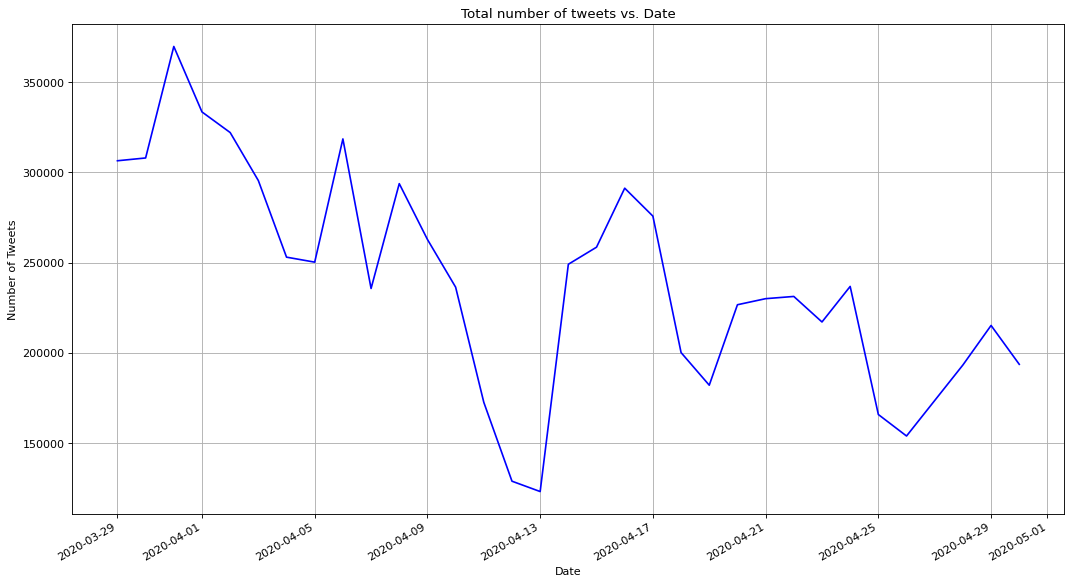

In [61]:
# Plot
plt.figure(figsize=(16, 9), dpi=80)
plt.plot(pandasDF_all['date'], pandasDF_all['count'], color="b")

plt.gcf().autofmt_xdate()

plt.xlabel('Date') 
plt.ylabel('Number of Tweets') 
  
# displaying the title
plt.title("Total number of tweets vs. Date")
plt.savefig('./task3_2.png')
plt.grid()

In [10]:
# Save the DF
pandasDF.to_csv('home.csv')
pandasDF_all.to_csv('all.csv')

In [57]:
# Get the relative ratio of tweets that has stay-home related hashtags
pandaDF_rel = pd.DataFrame()
pandaDF_rel['date'] = pandasDF['date']
pandaDF_rel['home'] = pandasDF['count']
pandaDF_rel['all'] = pandasDF_all['count']
pandaDF_rel['relative'] = pandasDF['count']/(pandasDF_all['count']*1.0)
pandaDF_rel.head()

,date,home,all,relative
0,2020-03-29,2795,306499,0.009119
1,2020-03-30,2743,308045,0.008905
2,2020-03-31,3063,369848,0.008282
3,2020-04-01,3079,333553,0.009231
4,2020-04-02,2926,322137,0.009083


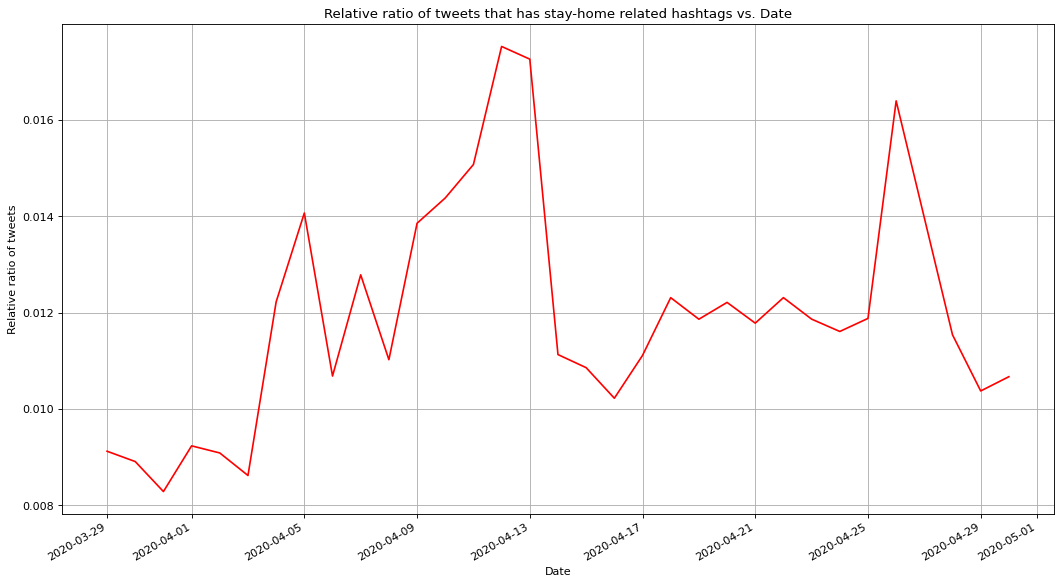

In [62]:
# Plot
plt.figure(figsize=(16, 9), dpi=80)
plt.plot(pandaDF_rel['date'], pandaDF_rel['relative'], color="r")

plt.gcf().autofmt_xdate()

plt.xlabel('Date') 
plt.ylabel('Relative ratio of tweets') 
  
# displaying the title
plt.title("Relative ratio of tweets that has stay-home related hashtags vs. Date")
plt.savefig('./task3_3.png')
plt.grid()

## Sentiment Analysis of Tweets that Have Stay-Home Related Hashtags

In [13]:
from wordcloud import WordCloud,STOPWORDS
stopwords = set(STOPWORDS)
from textblob import TextBlob
from collections import Counter

In [14]:
# Get the tweets containing stay home related hashtags
tweet_home = tweet_home_df.filter(tweet_home_df.lang == "en")
tweet_home = tweet_home.withColumn("date", F.regexp_extract(tweet_home['created_at'], r'(\d{4}-\d{2}-\d{2})',0)).cache()
df_home = tweet_home.toPandas()
df_home = df_home[['date', 'text']]
print(df_home.shape)
df_home.head()

2022-02-10 13:10:26,266 WARN execution.CacheManager: Asked to cache already cached data.


(88365, 2)


,date,text
0,2020-03-31,What's on the menu? Are you and your family co...
1,2020-03-31,"Earlier today, Medstar LifeFlight delivered me..."
2,2020-03-31,Top 10 ways to avoid COVID-19 that you may not...
3,2020-03-31,Remember to get outside today. Feeling stres...
4,2020-03-31,What can we do to get you all to understand th...


In [15]:
# Clean the data
for i in range(df_home.shape[0]) :
    df_home['text'][i] = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|(#[A-Za-z0-9]+)", " ", df_home['text'][i]).split()).lower()
df_home['text'].head()

0    what s on the menu are you and your family coo...
1    earlier today medstar lifeflight delivered med...
2    top 10 ways to avoid covid 19 that you may not...
3    remember to get outside today feeling stressed...
4    what can we do to get you all to understand th...
Name: text, dtype: object

In [16]:
# Remove Stop Words
df_home['text'] = df_home['text'].apply(lambda tweets: ' '.join([word for word in tweets.split() if word not in stopwords]))
df_home['text'].head() 

0    s menu family cooking together share videos ph...
1    earlier today medstar lifeflight delivered med...
2    top 10 ways avoid covid 19 may considered yet ...
3    remember outside today feeling stressed workin...
4              understand seriousness covid19 stayhome
Name: text, dtype: object

In [17]:
# Using TextBlob to analyze tweets to predict text sentiment and categorize as 'Positive', 'Negative' or 'Neutral'.
%time
df_home['sentiment'] = ' '
df_home['polarity'] = None
for i, tweet in enumerate(df_home.text) :
    blob = TextBlob(tweet)
    df_home['polarity'][i] = blob.sentiment.polarity
    if blob.sentiment.polarity > 0 :
        df_home['sentiment'][i] = 'positive'
    elif blob.sentiment.polarity < 0 :
        df_home['sentiment'][i] = 'negative'
    else :
        df_home['sentiment'][i] = 'neutral'
pd.set_option('display.max_colwidth', 400)
df_home.head()

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.58 µs


,date,text,sentiment,polarity
0,2020-03-31,s menu family cooking together share videos photos us recreation family thingstodo stayhome coronavirus community adult youth cooking baking,positive,0.1
1,2020-03-31,earlier today medstar lifeflight delivered medical supplies used help covid 19 patients mi macomb oakland hospital madison heights campus covid19 ems ambulance lifeflight essentialemployees alwaysopen healthcareheroes stayhomeforus wearemedstar,neutral,0.0
2,2020-03-31,top 10 ways avoid covid 19 may considered yet water covid19 hydrate health school stayhome health god pray today,positive,0.5
3,2020-03-31,remember outside today feeling stressed working take walk ergonomics stressreduction fitforwork ergonomicsatwork workplacewellness movemoresitless productivity healthyworkplace outdoors stayhome coronavirus covid 19 stayhealthy,neutral,0.0
4,2020-03-31,understand seriousness covid19 stayhome,neutral,0.0


In [18]:
# pandaDF_rel.to_csv('rel.csv')
# df_home[['date', 'sentiment']].to_csv('sen.csv')

In [24]:
df_positive = df_home[df_home.sentiment == 'positive'][['date', 'sentiment']]
df_neutral = df_home[df_home.sentiment == 'neutral'][['date', 'sentiment']]
df_negative = df_home[df_home.sentiment == 'negative'][['date', 'sentiment']]

In [25]:
# Number of tweets with different sentiments
df_positive.shape[0], df_neutral.shape[0], df_negative.shape[0]

(46369, 31350, 10646)

In [40]:
positive = df_positive.groupby('date')['sentiment'].count()
neutral = df_neutral.groupby('date')['sentiment'].count()
negative = df_negative.groupby('date')['sentiment'].count()
d = {'positive':list(positive), 'neutral':list(neutral), 'negative': list(negative)}
sentiment = pd.DataFrame(data=d)

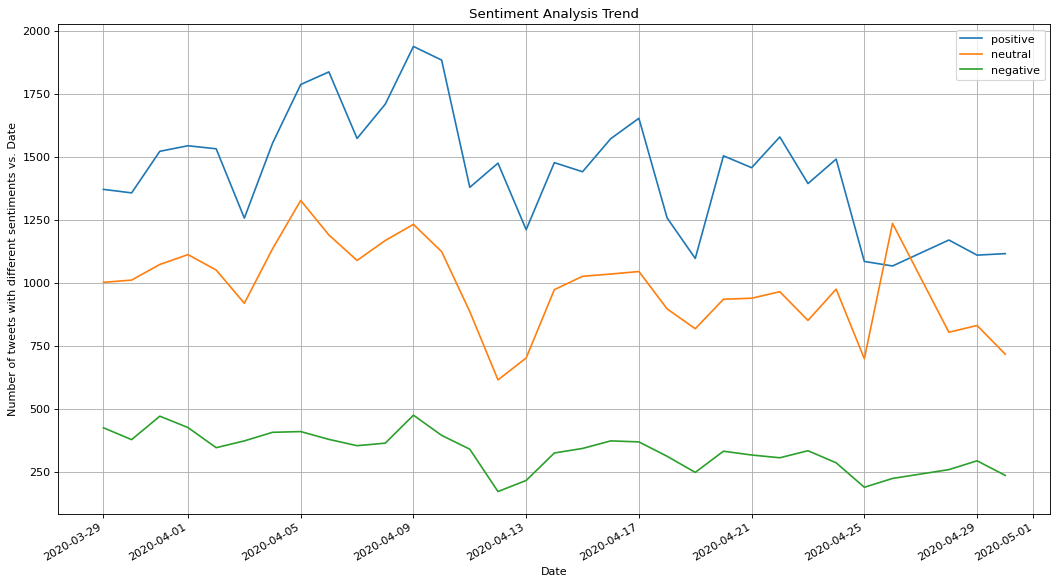

In [64]:
# Plot
plt.figure(figsize=(16, 9), dpi=80)
plt.title('Sentiment Analysis Trend')
plt.plot(pandasDF_all['date'], positive, label='positive')
plt.plot(pandasDF_all['date'], neutral, label='neutral')
plt.plot(pandasDF_all['date'], negative, label='negative')

plt.legend()

plt.xlabel('Date')
plt.ylabel('Number of tweets with different sentiments vs. Date')
plt.gcf().autofmt_xdate()
plt.savefig('./task3_4.png')
plt.grid()
plt.show()

In [58]:
pandaDF_rel[['positive', 'neutral', 'negative']] = sentiment[['positive', 'neutral', 'negative']]
pandaDF_rel['relative_pos'] = pandaDF_rel['positive']/(pandaDF_rel['home']*1.0)
pandaDF_rel['relative_neu'] = pandaDF_rel['neutral']/(pandaDF_rel['home']*1.0)
pandaDF_rel['relative_neg'] = pandaDF_rel['negative']/(pandaDF_rel['home']*1.0)
pandaDF_rel.head()

,date,home,all,relative,positive,neutral,negative,relative_pos,relative_neu,relative_neg
0,2020-03-29,2795,306499,0.009119,1370,1001,424,0.490161,0.358140,0.151699
1,2020-03-30,2743,308045,0.008905,1356,1010,377,0.494349,0.368210,0.137441
2,2020-03-31,3063,369848,0.008282,1521,1072,470,0.496572,0.349984,0.153444
3,2020-04-01,3079,333553,0.009231,1543,1111,425,0.501137,0.360831,0.138032
4,2020-04-02,2926,322137,0.009083,1531,1050,345,0.523240,0.358852,0.117908


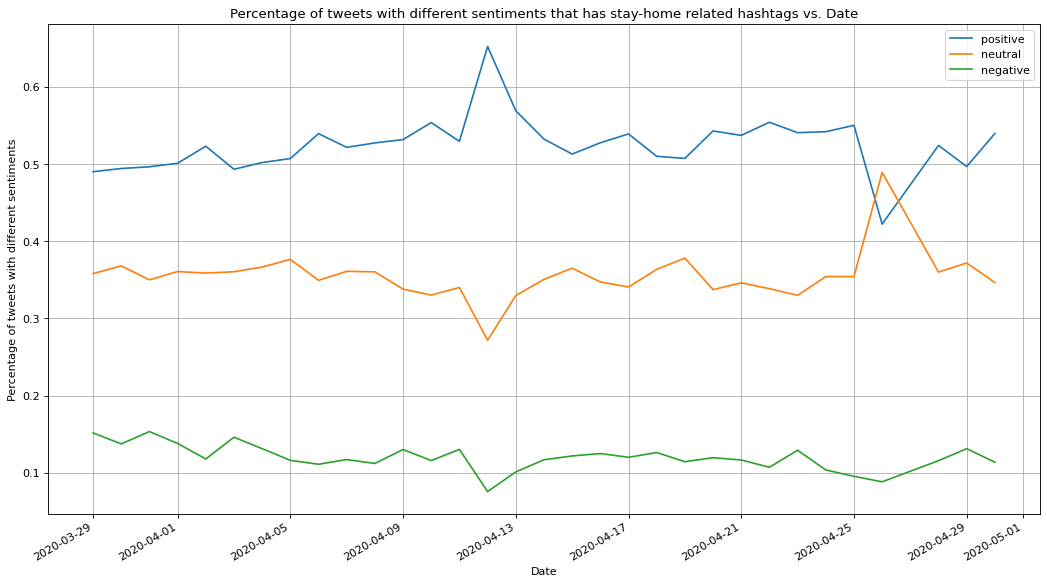

In [65]:
# Plot
plt.figure(figsize=(16, 9), dpi=80)
plt.title('Percentage of tweets with different sentiments that has stay-home related hashtags vs. Date')
plt.plot(pandasDF_all['date'], pandaDF_rel['relative_pos'], label='positive')
plt.plot(pandasDF_all['date'], pandaDF_rel['relative_neu'], label='neutral')
plt.plot(pandasDF_all['date'], pandaDF_rel['relative_neg'], label='negative')

plt.legend()

plt.xlabel('Date')
plt.ylabel('Percentage of tweets with different sentiments')
plt.gcf().autofmt_xdate()
plt.savefig('./task3_5.png')
plt.grid()
plt.show()

In [67]:
SparkSession.stop(spark)